# Best Practices for Model Evaluation and Hyperparameter Tuning

## Import Packages

In [1]:
import pandas as pd

## Pipelines in Sklearn

In [19]:
# Load Breast Cancer Wisconsin Dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features.values
y = breast_cancer_wisconsin_diagnostic.data.targets.values

In [20]:
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

In [21]:
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

In [22]:
# Perform label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

C:\Users\euler\.conda\envs\learning_machine_learning\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['B', 'M'], dtype=object)

In [23]:
le.transform(['M', 'B'])

array([1, 0])

In [24]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=31415926)

In [25]:
# Use Pipelines to perform Standardization, PCA and fit LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.956


## Assessing Model Performance using k-fold cross-validation

**Holdout Method**

- Separate data into three parts: A Training dataset, A Validation dataset, A Test dataset.
- Training dataset is used to fit the different models, Validation dataset is used to evaluate model performance for model selection. Test dataset is then used to obtain a less biased estimate of its ability to generalize new data.
- Disadvantage: Performance estimate is sensitive to how the data is partitioned.

**K-Fold Cross-Validation**

- Training dataset is randomly split into k-folds without replacement.
- k-1 folds are used for model training, and 1-fold is used for testing. (Test fold)
- This process is repeated k times.
- Average performance of models based on different, independent test folds are calculated.
- Generally, k-fold cross-validation is used for model tuning which is used to find optimal hyperparameter values.
- Advantage of k-fold cross validation is that each example is used only once.
- Leave-one-out cross-validation(LOOCV): Set the number of folds as number of examples. k = n, only one training example is used for testing during each iteration.
- Stratified k-fold cross-validation: Class label proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the training dataset.

In [26]:
# Use Stratified k fold to train the model on breast cancer dataset
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.978
Fold: 02, Class distr.: [256 153], Acc.: 0.891
Fold: 03, Class distr.: [256 153], Acc.: 0.935
Fold: 04, Class distr.: [256 153], Acc.: 0.913
Fold: 05, Class distr.: [256 153], Acc.: 0.978
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 1.000
Fold: 08, Class distr.: [257 153], Acc.: 0.956
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956


In [27]:
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


CV accuracy: 0.952 +/- 0.030


In [29]:
# Alternatively
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train, 
                         y=y_train, 
                         cv=10, 
                         n_jobs=-1)
print(f'CV accuracy scores: {scores}')
print(f"CV accuracy: {np.mean(scores):.3f}"
      f"+/- {np.std(scores):.3f}")

CV accuracy scores: [0.97826087 0.89130435 0.93478261 0.91304348 0.97826087 0.95555556
 1.         0.95555556 0.95555556 0.95555556]
CV accuracy: 0.952+/- 0.030


## Debugging Algorithms with Learning and Validation Curves

- Learning Curves can be used to diagnose bias and variance problem.
- `learning_curve` function uses stratified k-fold cross-validation to calculate the cross-validation accuracy of a classifier. Average accuracies are then calculated from the returned cross-validated training and test scores for different sizes of the training dataset. 
- Validation curves can be use to address overfitting and underfitting.
- Similarly, `validation_curve` uses k-fold cross-validation by default to estimate the performance of the classifier.

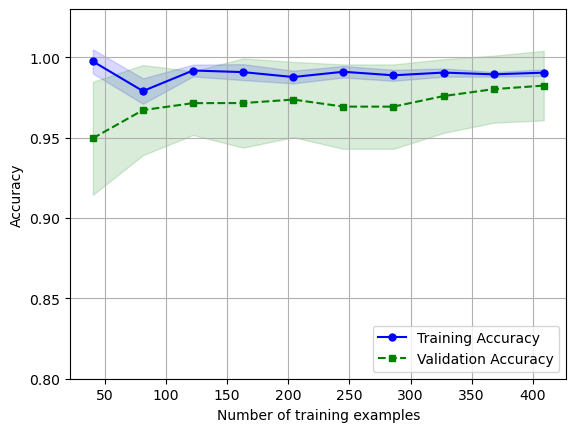

In [30]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression(penalty='l2', max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, 
                                                        y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=10, 
                                                        n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, 
         train_mean, 
         color='blue', 
         marker='o',
         markersize=5, 
         label='Training Accuracy')
plt.fill_between(train_sizes, 
                 train_mean + train_std, 
                 train_mean - train_std, 
                 alpha=0.15, 
                 color='blue')
plt.plot(train_sizes, 
         test_mean, 
         color='green', 
         linestyle='--', 
         marker='s', 
         markersize=5, 
         label='Validation Accuracy')
plt.fill_between(train_sizes, 
                 test_mean + test_std, 
                 test_mean - test_std, 
                 alpha=0.15, 
                 color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show();

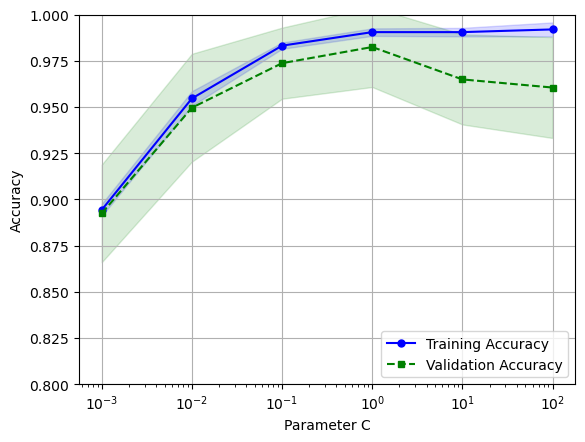

In [31]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                             X=X_train, 
                                             y=y_train, 
                                             param_name='logisticregression__C', 
                                             param_range=param_range, 
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, 
         train_mean, 
         color='blue', 
         marker='o', 
         markersize=5, 
         label='Training Accuracy')
plt.fill_between(param_range, 
                 train_mean + train_std, 
                 train_mean - train_std, 
                 alpha=0.15, 
                 color='blue')
plt.plot(param_range, 
         test_mean, 
         color='green', 
         linestyle='--', 
         marker='s', 
         markersize=5, 
         label='Validation Accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std, 
                 test_mean - test_std, 
                 alpha=0.15, 
                 color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show();

## Fine-Tuning Machine Learning Models

### Grid Search

- Grid Search is an exhaustive search and is guaranteed to find the optimal hyperparameter configuration if it is contained in the user-specified parameter grid.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state=31415926))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10, 
                  refit=True, 
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(f'Best Score of Grid Search: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score of Grid Search: 0.9780676328502416
Best Parameters: {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [33]:
# Training on best estimator
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')

Test Accuracy: 0.974


### Randomized Search

- Specifying large hyperparameter grids makes grid search costly.
- In Randomized Search, different parameter combinations are sampled.
- Hyperparameter configurations are randomly drawn from distributions. It does not perform exhaustive search over hyperparameter space.

In [34]:
import scipy
param_range = scipy.stats.loguniform(0.0001, 1000.0)
np.random.seed(31415926)
param_range.rvs(10)

array([7.66049587e-02, 8.89029752e+00, 2.55987189e-03, 3.97275905e-04,
       3.53593974e-04, 1.15161447e-01, 7.69133566e-02, 3.03883140e-01,
       1.21789192e+02, 5.85887788e+00])

In [35]:
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(), 
                         SVC(random_state=31415926))
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc, 
                        param_distributions=param_grid, 
                        scoring='accuracy', 
                        refit=True, 
                        n_iter=20, 
                        cv=10, 
                        random_state=31415926, 
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(f'Best score: {rs.best_score_}')
print(f'Best parameter: {rs.best_params_}')

Best score: 0.9758937198067633
Best parameter: {'svc__C': 0.6174678771025377, 'svc__kernel': 'linear'}


### HalvingRandomSearchCV

- Draw a large set of candidate configurations via random sampling.
- Train the models with limited resources; a small subset of the training data.
- Discard the bottom 50% based on predictive performance.
- Go back to step 2 with an increased amount of available resources.

In [37]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(pipe_svc, 
                           param_distributions=param_grid, 
                           n_candidates='exhaust', 
                           resource='n_samples', 
                           factor=1.5, 
                           random_state=31415926, 
                           n_jobs=-1)
hs = hs.fit(X_train, y_train)
print(f'Best Score: {hs.best_score_}')
print(f'Best Parameters: {hs.best_params_}')
# Select the best estimator
clf = hs.best_estimator_
print(f'test Accuracy: {hs.score(X_test, y_test):.3f}')

Best Score: 0.9764705882352942
Best Parameters: {'svc__C': 0.6174678771025377, 'svc__kernel': 'linear'}
test Accuracy: 0.982


## Performance Evaluation Metrics

- Confusion Matrix: Square Matrix that reports the counts of the *True Positive*, *True Negative*, *False Positive*, *False Negative*.
- **Precision, Recall**
    - Prediction error: $ERR = \frac{FP + FN}{FP + FN + TP + TN}$
    - Prediction Accuracy: $ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR$
    - True Positive Rate: $TPR = \frac{TP}{P} = \frac{TP}{FN + TP}$
    - False Positive Rate: $FPR = \frac{FP}{N} = \frac{FP}{FP + TN}$
    - RECALL = TPR; Quantifies how many of relevant records(the positives) are captured as (the true positives).
    - $PRECISION = \frac{TP}{TP + FP}$; Quantifies how many of the records predicted as relevant(Sum of true positives and false positives) are actually relevant(true positives).
- Optimizing for recall helps with minimizing the chance of not predicting the true positive rate.
- However, doing it comes at a cost of high false positives.
- Conversely, optimizing precision comes at a cost of high number of FNs.
- To balance up- and downsides of optimizing Precision and Recall, harmonic mean of Precision and Recall is used: $F1 = 2\frac{PRECISION X RECALL}{PRECISION + RECALL}$
- Mathews Correlation Coefficient(MCC) summarizes a confusion matrix. It is used in biological research. $MCC = \frac{TP X TN - FP X FN}{\sqrt(TP+FP)(TP+FN)(TN+FP)(TN+FN)}$

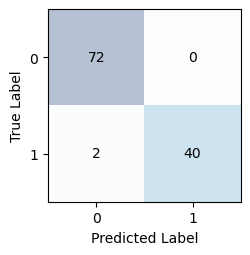

In [40]:
from sklearn.metrics import confusion_matrix
# Fit the model
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show();

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 1.000
Recall: 0.952
F1: 0.976
MCC: 0.963


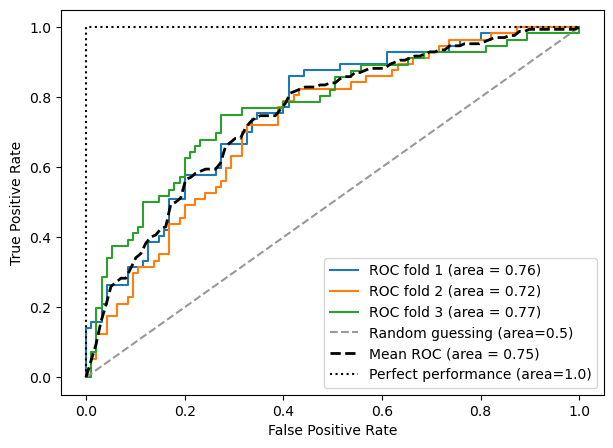

In [43]:
# Plotting a receiver operating characteristic
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(
    StandardScaler(), 
    PCA(n_components=2), 
    LogisticRegression(penalty='l2', random_state=31415926, solver='lbfgs', C=100.0)
)
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(
        X_train2[train], 
        y_train[train]
    ).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], 
                                     probas[:, 1], 
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         linestyle=':', 
         color='black', 
         label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show();